# Lab 4-: Mixture Models+Model orden selection 

The goal of this lab session is to study mixture models. In the first part you will code the EM algorithm to estimate the parameters of a GMM given the number of mixed distributions and in the second part you will try different model order selection methods. You will send only one notebook for both parts **(this notebook will be updated with instructions for the second part and the deadline)**.

You have to send the filled notebook named **"L4__familyname1_familyname2.ipynb"** (groups of 2) by email to aml.centralesupelec.2019@gmail.com and put **"AML-L4- "** in the subject. 

We begin with the standard imports:

In [93]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import multivariate_normal
%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.5, 's' : 80, 'linewidths':0}

## GMM

A Gaussian mixture model is a probabilistic model that assumes all the data points are generated from a mixture of a finite number of Gaussian distributions with unknown parameters. After estimation of those parameters we get an estimation of the distribution of our data. For the clustering task, one can think of mixture models as generalizing k-means clustering to incorporate information about the covariance structure of the data as well as the centers of the latent Gaussians. 

### First part

Fill in the following class to implement a multivariate GMM:

In [304]:
class my_GMM():
    
    def __init__(self, k):
        '''
        Parameters:
        k: integer
            number of components
        
        Attributes:
        
        alpha_: np.array
            proportion of components
        mu_: np.array
            array containing means
        Sigma_: np.array
            array cointaining covariance matrix
        cond_prob_: (n, K) np.array
            conditional probabilities for all data points 
        labels_: (n, ) np.array
            labels for data points
        '''
        self.k = k
        self.alpha_ = None
        self.mu_ = None
        self.Sigma_ = None
        self.cond_prob_ = None
        self.labels_ = None
        
    def fit(self, X, initialization = 'random', tol = 10**-6, it_max = 100):
        """ Find the parameters
        that better fit the data
        
        Parameters:
        -----------
        X: (n, p) np.array
            Data matrix
        
        Returns:
        -----
        self
        """
        n, p = X.shape
        k = self.k
        if initialization == 'random' :
            self.mu_ = 1- 2 * np.random.rand(k, p)
            self.Sigma_ = np.zeros((k, p, p))
            for i in range(k) :
                self.Sigma_[i, :] = make_sparse_spd_matrix(p)
            self.alpha_ = np.random.rand(k)
            self.alpha_ = self.alpha_/np.sum(self.alpha_)
        
        self.cond_prob_ = np.zeros((n, k))
            
        # TODO:
        # initialize the parameters
        # apply sklearn kmeans or randomly initialize them
        
        it = 0
        convergence = False
        
        while not convergence :
            density = np.zeros((n, k))
            for i in range (k):
                density[:, i] = np.random.multivariate_normal.pdf(X, mean=self.mu_[i], cov=self.Sigma_[i])
            
            cond_prob_ = self.alpha_.T * density
            cond_prob_ = cond_prob_ / np.expand_dims(np.sum(cond_prob_, axis = 1), axis = 1)
            delta_cond_prob = np.max(np.abs(self.cond_prob_ - cond_prob_))
            self.cond_prob_ = cond_prob_ 
            
            alpha_ = np.mean(self.cond_prob_, axis = 0)
            delta_alpha = np.max(np.abs(self.alpha_ - alpha_))
            self.alpha_ = alpha_
                                 
            mu_ = (1/self.alpha_)[:, np.newaxis] * np.mean(np.expand_dims(X, axis = 1) * self.cond_prob_[:, :, np.newaxis], axis = 0)
            delta_mu_ = np.max(np.abs(self.mu_ - mu_))
            self.mu_ = mu_
            
            tmp = np.expand_dims(X, axis=1) - np.expand_dims(self.mu_, axis = 0)
            Sigma_ = (1/self.alpha_)[:, np.newaxis, np.newaxis] * np.mean(self.cond_prob_[:, :, np.newaxis, np.newaxis ] * np.matmul(np.expand_dims(tmp, -1), np.expand_dims(tmp, 2)),
                                              axis = 0)
            delta_sigma = np.max(np.abs(self.Sigma_ - Sigma_))
            self.Sigma_ = Sigma_
            it = it + 1
            err = delta_alpha + delta_cond_prob + delta_mu_ + delta_sigma
            if it > it_max or (err < tol) :
                convergence  = True
            
            
            ## RAJOUTER UN CRITERE DE CONVERGENCE 
            
        #     Compute conditional probability matrix
        #     Update parameters
        
        # Update labels_
        print("Fin du fitting à l'iteration :", it , '. Error : ', err)
        self.labels_ = np.argmax(self.cond_prob_, axis = 1)
        
        return self
        
    def predict(self, X):
        """ Predict labels for X
        
        Parameters:
        -----------
        X: (n, p) np.array
            New data matrix
        
        Returns:
        -----
        label assigment        
        """
        cond_prob_ = self.compute_proba(X)
        
        return np.argmax(cond_prob_, axis = 1)
        
        
    def compute_proba(self, X):
        """ Compute probability vector for X
        
        Parameters:
        -----------
        X: (n, p) np.array
            New data matrix
        
        Returns:
        -----
        proba: (n, k) np.array        
        """
        n = X.shape[0]
        density = np.zeros((n, k))
        for i in range (k):
            density[:, i] = multivariate_normal.pdf(X, mean=self.mu_[i], cov=self.Sigma_[i])

        cond_prob_ = self.alpha_.T * density
        cond_prob_ = self.cond_prob_ / np.sum(self.cond_prob_, axis = 1)
        return cond_prob_

Fin du fitting à l'iteration : 55 . Error :  8.268136175715313e-11


Generate your own mixture of Gaussian distributions to test the model, choose parameters so that GMM performs better than K-Means on it. Use `np.random.multivariate_normal`. 

Plot data with colors representing predicted labels and shapes representing real labels.

In [112]:
## Génération d'une mixture de k gaussiennes
k = 4
p = 2
np.random.seed(1)
list_of_x = []
labels = []
for i in range(k) :
    n_i = np.random.randint(100, 1000)
    mu_i = (i+1) * (1 - 2* np.random.rand(p))
    vec_cov_i = np.random.rand(p, p)
    cov_i = np.dot(vec_cov_i, vec_cov_i.T)
    x_i = np.random.multivariate_normal(mu_i, cov_i, n_i)
    list_of_x.append(x_i)
    labels.append(i * np.ones(n_i))
X = np.concatenate(list_of_x)
labels = np.concatenate(labels)
shuffle = np.arange(len(X))
np.random.shuffle(shuffle)
X = X[shuffle]
labels = labels[shuffle]   

Fin du fitting à l'iteration : 56 . Error :  7.359901577075334e-11


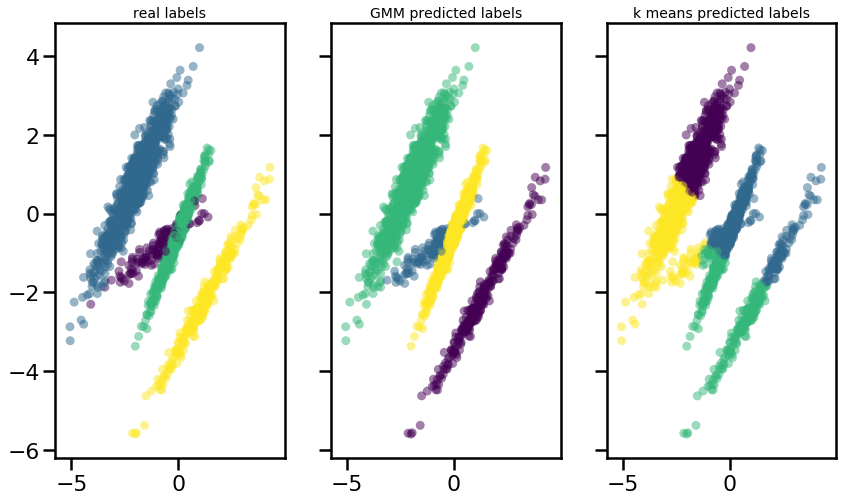

In [315]:
##Fitting et comparaison avec d'autres modèles

model = my_GMM(k)
model.fit(X, it_max = 1000, tol = 10**-10);

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, max_iter=200).fit(X)
fig, ax = plt.subplots(1,3, figsize =(14, 8), sharex = True, sharey = True)
ax[0].scatter(X[:, 0].T, X[:, 1].T, c=labels, **plot_kwds)
ax[0].set_title('real labels', size = 14)
ax[1].scatter(X[:, 0].T, X[:, 1].T, c=model.labels_, **plot_kwds)
ax[1].set_title('GMM predicted labels', size = 14);
ax[2].scatter(X[:, 0].T, X[:, 1].T, c=kmeans.labels_, **plot_kwds)
ax[2].set_title('k means predicted labels', size = 14);

Fin du fitting à l'iteration : 340 . Error :  9.759786034901907e-11


Text(0.5, 1.0, 'kmeans prediction')

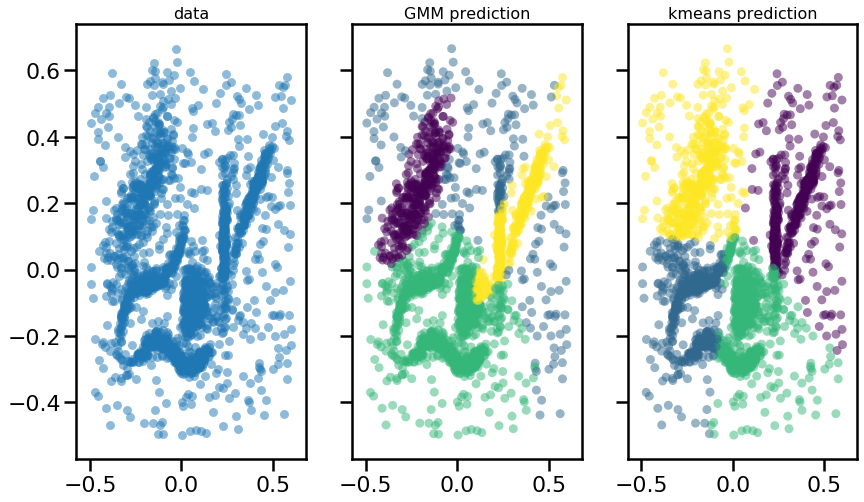

In [321]:
test_data_1 = np.load('data/clusterable_data.npy')
kmeans_1 = KMeans(n_clusters=4, max_iter=200).fit(test_data_1)
model = my_GMM(k=4)
model.fit(test_data_1, it_max = 1000, tol = 10**-10);

fig, ax = plt.subplots(1,3, figsize =(14, 8), sharex = True, sharey = True)
ax[0].scatter(test_data_1.T[0], test_data_1.T[1], **plot_kwds)
ax[0].set_title('data', size=16)

ax[1].scatter(test_data_1.T[0], test_data_1.T[1], c=model.labels_, **plot_kwds)
ax[1].set_title('GMM prediction', size=16)

ax[2].scatter(test_data_1.T[0], test_data_1.T[1], c=kmeans_1.labels_, **plot_kwds)
ax[2].set_title('kmeans prediction', size=16)

#### Bonus (not graded): Implement a mixture of asymmetric generalized Gaussians (AGGD)

### Second Part
 
To be updated